# Multiple Results Analysis

This notebook is intended to read a simulation results file with multiple simulations and results and create aggregate analyses and visualizations.

In [155]:
%matplotlib inline

import os
import sys 
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tabulate import tabulate
from operator import itemgetter
from itertools import groupby, chain
from collections import defaultdict, Counter

# Modify the Notebook path
sys.path.append(os.path.join(os.getcwd(), ".."))

In [156]:
sns.set_style('whitegrid')
sns.set_context('notebook')

In [157]:
# Specify a path to a results file 
# If None, will attempt to look one up
FIXTURES = os.path.join("..", "fixtures")
RESULTS  = os.path.join(FIXTURES, 'test-user-multi.json')

def get_results_data(path=RESULTS):
    with open(path, 'r') as f:
        return json.load(f)

# Load the data
data = get_results_data()

# Get all the values for a particular key 
def results_values(*key):
    for result in data:
        value = result
        for k in key:
            value = value.get(k, {})
        yield value

rvals = results_values

In [158]:
# Print report details 
def report_settings():
    table = defaultdict(list)
    exclude = frozenset([
        'valid_locations', 'invalid_types', 
        'default_replica', 'default_consistency', 'default_latency', 
        'max_sim_time', 'title', 'description',
        'election_timeout', 'heartbeat_interval',
    ])
    
    for idx, conf in enumerate(rvals('settings')):
        eid = "e{:0>2}".format(idx)
        for key, val in conf.iteritems():
            if key in exclude: continue 
            if key == 'anti_entropy_delay': key = 'anti_entropy'
            if idx == 0:
                table[''].append(key)
            table[eid].append(val)
    
    for idx, conf in enumerate(rvals('topology', 'meta')):
        eid = "e{:0>2}".format(idx)
        for key, val in conf.iteritems():
            if key in exclude: continue 
            if idx == 0:
                table[''].append(key)
            table[eid].append(val)

    return tabulate(table, headers='keys')

print report_settings()

               e22          e29          e30          e19          e18          e35          e34          e33          e32          e31          e23          e11          e10          e13         e12      e15          e14          e17          e16          e28          e24      e25         e26          e27          e20          e21          e08          e09          e06          e07          e04          e05          e02          e03          e00      e01
-------------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  ----------  -------  -----------  -----------  -----------  -----------  -----------  -------  ----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -------  ----------
do_rumoring    True         True         True         True         True  

In [159]:
def report_accesses(access='write'):
    table = defaultdict(list)
    
    for idx, results in enumerate(rvals('results')):
        counts = Counter()
        eid = "e{:0>2}".format(idx)
        
        for (rid, loc, ts) in results.get(access, []):
            counts[rid] += 1
            counts['total'] += 1
        
        for rid, count in sorted(counts.items(), key=itemgetter(0)):
            if idx == 0:
                table[''].append(rid)
            table[eid].append(count)
    
    print "{} Accesses:\n".format(access.capitalize())
    print tabulate(table, headers='keys')
    return table

table = report_accesses('read')

Read Accesses:

         e22    e29    e30    e19    e18    e35    e34    e33    e32    e31    e23    e11    e10    e13    e12    e15    e14    e17    e16    e28    e24    e25    e26    e27    e20    e21    e08    e09    e06    e07    e04    e05    e02    e03    e00    e01
-----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----
r0       601   1024   1022    645    643    985   1058   1135    999    997    627    183    219    571    645    643    614    636    569   1107    978    995   1089   1029    693    601    201    241    240    197    206    168    234    199    190    214
r1       610    931    944    594    648   1054   1031   1032   1051   1007    584    177    206    641    566    546    542    548    601    974   1032   1090    981   1002    594    604    146    238    166  

In [160]:
table = report_accesses('write')

Write Accesses:

         e22    e29    e30    e19    e18    e35    e34    e33    e32    e31    e23    e11    e10    e13    e12    e15    e14    e17    e16    e28    e24    e25    e26    e27    e20    e21    e08    e09    e06    e07    e04    e05    e02    e03    e00    e01
-----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----
r0       290    463    432    289    272    475    493    506    515    493    269     80    104    318    304    315    288    305    297    514    510    453    508    497    323    300     89    110     98    102    102     91    107    110     93    114
r1       246    463    452    272    285    451    500    474    510    503    264     92    104    303    264    284    276    258    289    455    470    502    454    458    264    294     70     95    101 

In [161]:
def create_dataframe():
    table = []
    meta  = list(rvals('topology', 'meta'))
    conf  = list(rvals('settings'))

    for idx, results in enumerate(rvals('results')):
        data = {'eid': "e{:0>2}".format(idx)}
        data['variable (ms)'] = meta[idx]['variable']
        
        latency = meta[idx]['variable'].rstrip('ms').split('-')
        latency = sum(map(float, latency)) / 2
        
        data['mean latency (ms)'] = latency
        data['constant (ms)'] = meta[idx]['constant']
        data['users'] = conf[idx]['users']
        for key, values in results.iteritems():
            if key == 'visibility latency':
                data['visibility latency (ms)'] = sum(v[3] - v[2] for v in values) / len(values)
                data['visible writes'] = len(set([v[1] for v in values]))
            else:
                data[key] = len(values)
        
        data['ratio fully visible to writes'] = float(data['visible writes']) / float(data['write'])
        
        table.append(data)
    
    return pd.DataFrame(table)

df = create_dataframe()
print df

   constant (ms)  eid  mean latency (ms)  ratio fully visible to writes  read  \
0         N/A ms  e00                255                       0.951344  1601   
1         N/A ms  e01                755                       0.922780  1633   
2         N/A ms  e02               1255                       0.868456  1652   
3         N/A ms  e03               1755                       0.821664  1618   
4         N/A ms  e04               2255                       0.795573  1612   
5         N/A ms  e05               2755                       0.807198  1630   
6         N/A ms  e06               3255                       0.753316  1636   
7         N/A ms  e07               3755                       0.744341  1637   
8         N/A ms  e08               4255                       0.726797  1619   
9         N/A ms  e09               4755                       0.764543  1658   
10        N/A ms  e10               5255                       0.693316  1618   
11        N/A ms  e11       

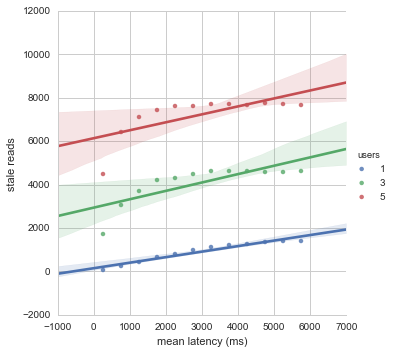

In [162]:
ax = sns.lmplot(x="mean latency (ms)", y="stale reads", hue='users', data=df)

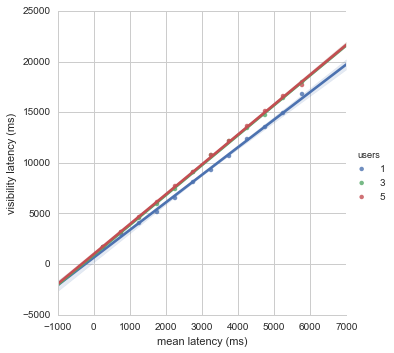

In [163]:
ax = sns.lmplot(x="mean latency (ms)", y="visibility latency (ms)", hue='users', data=df)

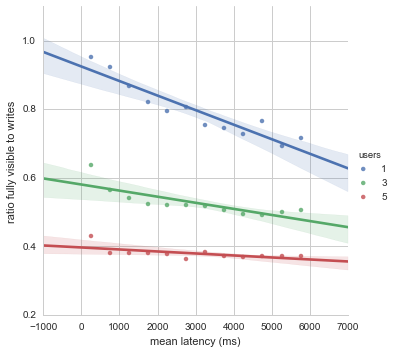

In [164]:
ax = sns.lmplot(x="mean latency (ms)", y="ratio fully visible to writes", hue='users', data=df)